In [597]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.constants import c

In [598]:
class DiscretField:
    def __init__(self, value):
        self.complex = value

    @property
    def intensity(self):
        return np.abs(self.complex)

In [599]:
class Telescope:
    def __init__(self, x, y, image_size=100, resolution=0.001*u.arcsec):
        # position relative to the origin of the interferometer
        self.Bx = x 
        self.By = y
        
        # image size and resolution
        self.image_size = image_size
        self.resolution = resolution
        
        # compute the phase map
        self.x_pixel_map, self.y_pixel_map = np.meshgrid(np.arange(self.image_size)-self.image_size//2, np.arange(self.image_size)-self.image_size//2)
        self.phi_angle_map = self.x_pixel_map * self.resolution
        self.theta_angle_map = self.y_pixel_map * self.resolution

    def observe(self, sky):
        self.phase_map = (self.Bx * np.sin(self.phi_angle_map.to(u.rad).value) + self.By * np.sin(self.theta_angle_map.to(u.rad).value)) / sky.wavelength
        
        self.field = DiscretField(sky(self.phi_angle_map.value, self.theta_angle_map.value) * np.exp(1j * self.phase_map))

t1 = Telescope(-30*u.m, -50*u.m)
t2 = Telescope(10*u.m, 30*u.m)
t3 = Telescope(-10*u.m, 10*u.m)
t4 = Telescope(50*u.m, -10*u.m)

telescopes = [t1, t2, t3, t4]

In [600]:
class Sky:
    def __init__(self, function, wavelength):
        self.function = function
        self.wavelength = wavelength

    def __call__(self, x, y):
        return self.function(x, y)
    
def white_sky(phi,theta):
    return (1+0j)*u.cd + 0*phi*theta * u.cd

sky = Sky(function=white_sky, wavelength=1*u.um)

In [601]:
for t in telescopes:
    t.observe(sky)

E1, E2, E3, E4 = t1.field.complex, t2.field.complex, t3.field.complex, t4.field.complex

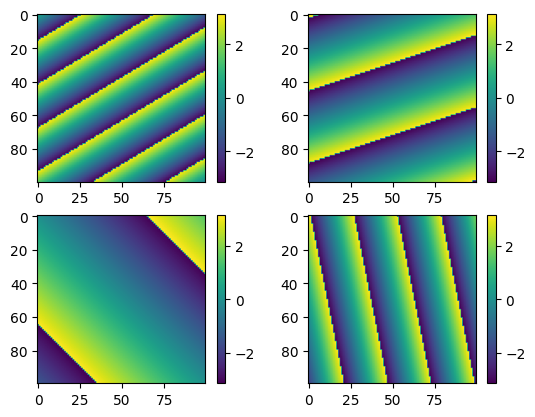

In [602]:
plt.subplot(221)
plt.imshow(np.angle(t1.field.complex.value))
plt.colorbar()
plt.subplot(222)
plt.imshow(np.angle(t2.field.complex.value))
plt.colorbar()
plt.subplot(223)
plt.imshow(np.angle(t3.field.complex.value))
plt.colorbar()
plt.subplot(224)
plt.imshow(np.angle(t4.field.complex.value))
plt.colorbar()
plt.show()

In [603]:
def Nuller(E1, E2, E3, E4):
    N0 = 1/2 * (E1 + E2 + E3 + E4)
    N1 = 1/2 * (E1 + E2 - E3 - E4)
    N2 = 1/2 * (E1 - E2 + E3 - E4)
    N3 = 1/2 * (E1 - E2 - E3 + E4)
    return N0, N1, N2, N3

N0, N1, N2, N3 = Nuller(E1, E2, E3, E4)

Nulls (cd)


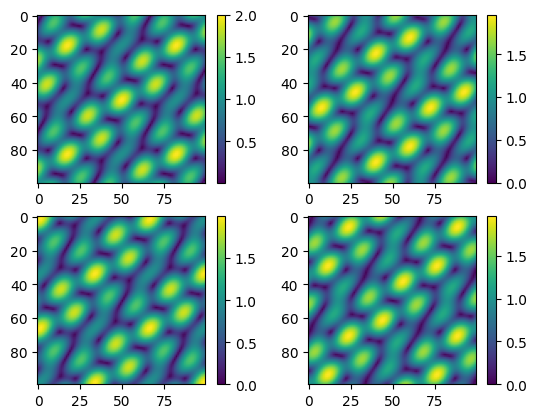

Center brightness for N0: 2.0 cd
Center brightness for N1: 0.0 cd
Center brightness for N2: 0.0 cd
Center brightness for N3: 0.0 cd


In [604]:
print(f"Nulls ({np.abs(N0).unit})")
plt.subplot(221)
plt.imshow(np.abs(N0).value)
plt.colorbar()
plt.subplot(222)
plt.imshow(np.abs(N1).value)
plt.colorbar()
plt.subplot(223)
plt.imshow(np.abs(N2).value)
plt.colorbar()
plt.subplot(224)
plt.imshow(np.abs(N3).value)
plt.colorbar()
plt.show()

print(f"Center brightness for N0: {np.abs(N0[50,50])}")
print(f"Center brightness for N1: {np.abs(N1[50,50])}")
print(f"Center brightness for N2: {np.abs(N2[50,50])}")
print(f"Center brightness for N3: {np.abs(N3[50,50])}")

In [605]:
def S(N1, N2, N3):
    theta = np.pi/2
    S1 = 1/2 * ( N1                   + N2*np.exp(1j*theta))
    S2 = 1/2 * (-N1*np.exp(-1j*theta) + N2                 )
    S3 = 1/2 * ( N1                   + N3*np.exp(1j*theta))
    S4 = 1/2 * (-N1*np.exp(-1j*theta) + N3                 )
    S5 = 1/2 * ( N2                   + N3*np.exp(1j*theta))
    S6 = 1/2 * (-N2*np.exp(-1j*theta) + N3                 )
    return S1, S2, S3, S4, S5, S6

S1, S2, S3, S4, S5, S6 = S(N1, N2, N3)

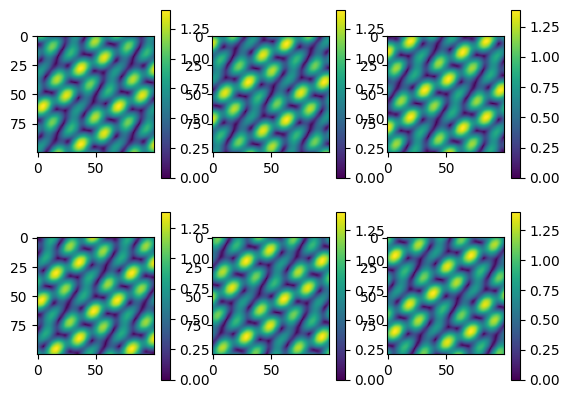

In [606]:
plt.subplot(231)
plt.imshow(np.abs(S1).value)
plt.colorbar()
plt.subplot(232)
plt.imshow(np.abs(S2).value)
plt.colorbar()
plt.subplot(233)
plt.imshow(np.abs(S3).value)
plt.colorbar()
plt.subplot(234)
plt.imshow(np.abs(S4).value)
plt.colorbar()
plt.subplot(235)
plt.imshow(np.abs(S5).value)
plt.colorbar()
plt.subplot(236)
plt.imshow(np.abs(S6).value)
plt.colorbar()
plt.show()

In [607]:
def K(S1,S2,S3,S4,S5,S6):
    K1 = S1 - S2
    K2 = S3 - S4
    K3 = S5 - S6
    return K1, K2, K3

K1, K2, K3 = K(S1, S2, S3, S4, S5, S6)

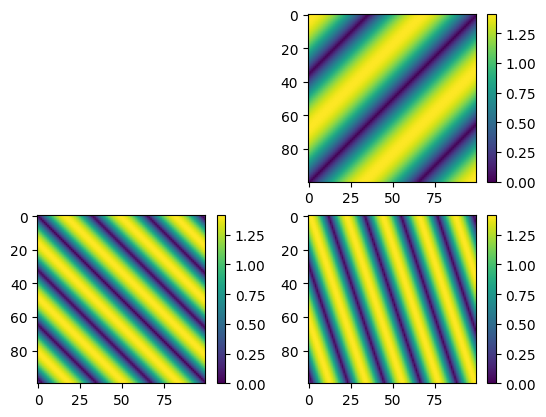

In [608]:
plt.subplot(222)
plt.imshow(np.abs(K1).value)
plt.colorbar()
plt.subplot(223)
plt.imshow(np.abs(K2).value)
plt.colorbar()
plt.subplot(224)
plt.imshow(np.abs(K3).value)
plt.colorbar()
plt.show()

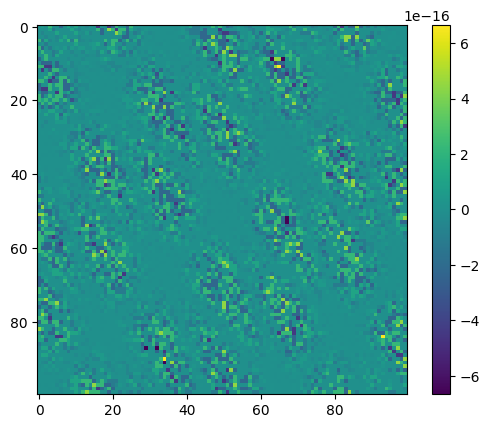

In [613]:
plt.imshow(np.abs(np.conjugate(K1) * K2 * K3).value)
plt.colorbar()
plt.show()

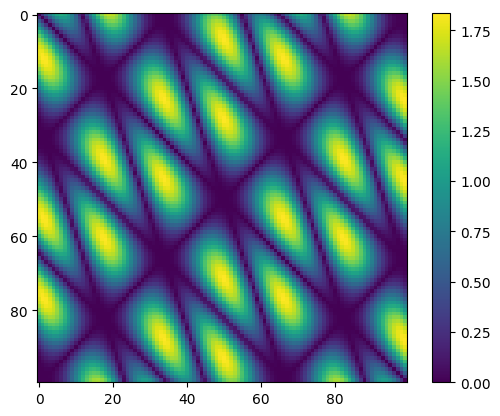

In [610]:
plt.imshow(np.abs(K1 * np.conjugate(K2) * K3).value)
plt.colorbar()
plt.show()

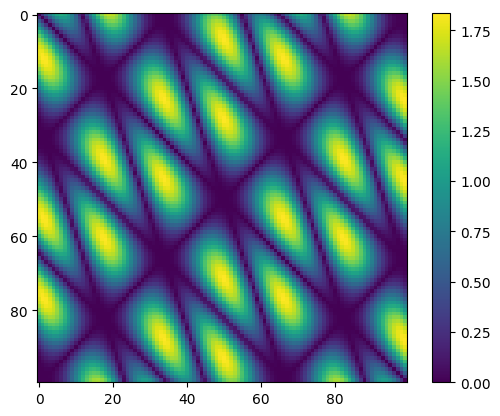

In [611]:
plt.imshow(np.abs(K1 * K2 * np.conjugate(K3)).value)
plt.colorbar()
plt.show()